In [1]:
import numpy as np
import datetime
import glob
import os
import matplotlib.pyplot as plt
import cartopy
from matplotlib import gridspec
import itertools
import cartopy.crs as ccrs
import tqdm
import netCDF4 as nc 
from scipy.stats import linregress
from pyproj import Proj, Transformer
from scipy.interpolate import griddata

import warnings
import pickle
warnings.filterwarnings("ignore")


In [2]:
def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion

def lonlat_to_xy(coords_1, coords_2, hemisphere, inverse=False):

    """Converts between longitude/latitude and EASE xy coordinates.
 
    Args:
        lon (float): WGS84 longitude
        lat (float): WGS84 latitude
        hemisphere (string): 'n' or 's'
        inverse (bool): if true, converts xy to lon/lat
 
    Returns:
        tuple: pair of xy or lon/lat values
    """

    EASE_Proj = {'n': 'EPSG:3408',
                 's': 'EPGS:3409'}
    
    WGS_Proj = 'EPSG:4326'
    
    #for coords in [coords_1, coords_2]: assert isinstance(coords,(np.ndarray,list))

    if inverse == False: # lonlat to xy
        
        lon, lat = coords_1, coords_2
        
        transformer = Transformer.from_crs(WGS_Proj, EASE_Proj[hemisphere])
        
        x, y = transformer.transform(lat, lon)
        
        return (x, y)

    else: # xy to lonlat
        
        x, y = coords_1, coords_2
        
        transformer = Transformer.from_crs(EASE_Proj[hemisphere], WGS_Proj)
        
        lat, lon = transformer.transform(x, y)
        
        return (lon, lat)

In [3]:
# Load inverse SIT CS_IS_2p_LARM

inverseCSIS20182019 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy']

inverseCSIS20192020 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy']

inverseCSIS20202021 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202011/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202012/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202101/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202102/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202103/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202104/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy']

inverse_CSIS = [inverseCSIS20182019, inverseCSIS20192020, inverseCSIS20202021]


inverseCSAK20182019 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy']

inverseCSAK20192020 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy']

inverseCSAK20202021 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202011/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202012/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202101/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202102/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202103/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202104/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy']

inverse_CSAK = [inverseCSAK20182019, inverseCSAK20192020, inverseCSAK20202021]

In [4]:
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

IS2 = [np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2018_25km_20181115.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20190415.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191115.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200415.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20201115.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2021_25km_20210415.npy")]


amsr2_snow_files = ['/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20181115_ease_25_v0.2.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20190415_ease_25_v0.2.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20191115_ease_25_v0.2.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20200415_ease_25_v0.2.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20201115_ease_25_v0.2.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20210415_ease_25_v0.2.nc']

    # fpath = '/home/cn/Sentinel3Snod/DATA/Bremen_snow/2019/03/snowdepth_amsr2_20190315v1.1.nc'



import xarray as xr

def get_pm_bremen_snow_lonlats():
    fpath = '/home/erb/masterproject/MSCI_project/validation_data/AMSR2/mpr_retrieval_amsr_20181115_ease_25_v0.2.nc'
    ds = xr.open_dataset(fpath)
    return ds['lon'].values, ds['lat'].values

def get_pm_bremen_snow_values(fpath):
    # fpath = '/home/cn/Sentinel3Snod/DATA/Bremen_snow/2019/03/snowdepth_amsr2_20190315v1.1.nc'
    ds = xr.open_dataset(fpath)
    return ds['snd'].values



lon_AMSR2, lat_AMSR2 = get_pm_bremen_snow_lonlats()
# snow_AMSR2, snow_unc_AMSR2 = get_pm_bremen_snow_values()

x_AMSR2, y_AMSR2 = lonlat_to_xy(lon_AMSR2, lat_AMSR2, "n", inverse=False)

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

x_EASE2, y_EASE2 = lonlat_to_xy(lon_g, lat_g, "n", inverse=False)


def snow_amsr2(path_awismos):

    snow_AMSR2 = get_pm_bremen_snow_values(path_awismos)
    snow_AMSR2_EASE2 = griddata((x_AMSR2.ravel(), y_AMSR2.ravel()), snow_AMSR2.ravel(), (x_EASE2, y_EASE2), method='nearest')
    #snow_AMSR2_EASE2 = snow_AMSR2_EASE2/100.
    snow_AMSR2_EASE2 = snow_AMSR2_EASE2
    return snow_AMSR2_EASE2

def inverse_snow(inverse_snow_files, path_awismos):
    snow_inverse, ST_amsr2 = [], []

    snow_AMSR2 = get_pm_bremen_snow_values(path_awismos)
    snow_AMSR2_EASE2 = griddata((x_AMSR2.ravel(), y_AMSR2.ravel()), snow_AMSR2.ravel(), (x_EASE2, y_EASE2), method='nearest')
    #snow_AMSR2_EASE2 = snow_AMSR2_EASE2/100.
    snow_AMSR2_EASE2 = snow_AMSR2_EASE2
    
    snow_inverse_data = np.load(inverse_snow_files)

    for k in range(360):
        for j in range(360):
        #if not SIT_awismos.mask[k][j] and not np.isnan(ice_inverse_data[k][j]):
            if not np.isnan(snow_inverse_data[k][j]) and not np.isnan(snow_AMSR2_EASE2[k][j]):
                snow_inverse.append(snow_inverse_data[k][j])
                ST_amsr2.append(snow_AMSR2_EASE2[k][j])
    
    return snow_inverse, ST_amsr2

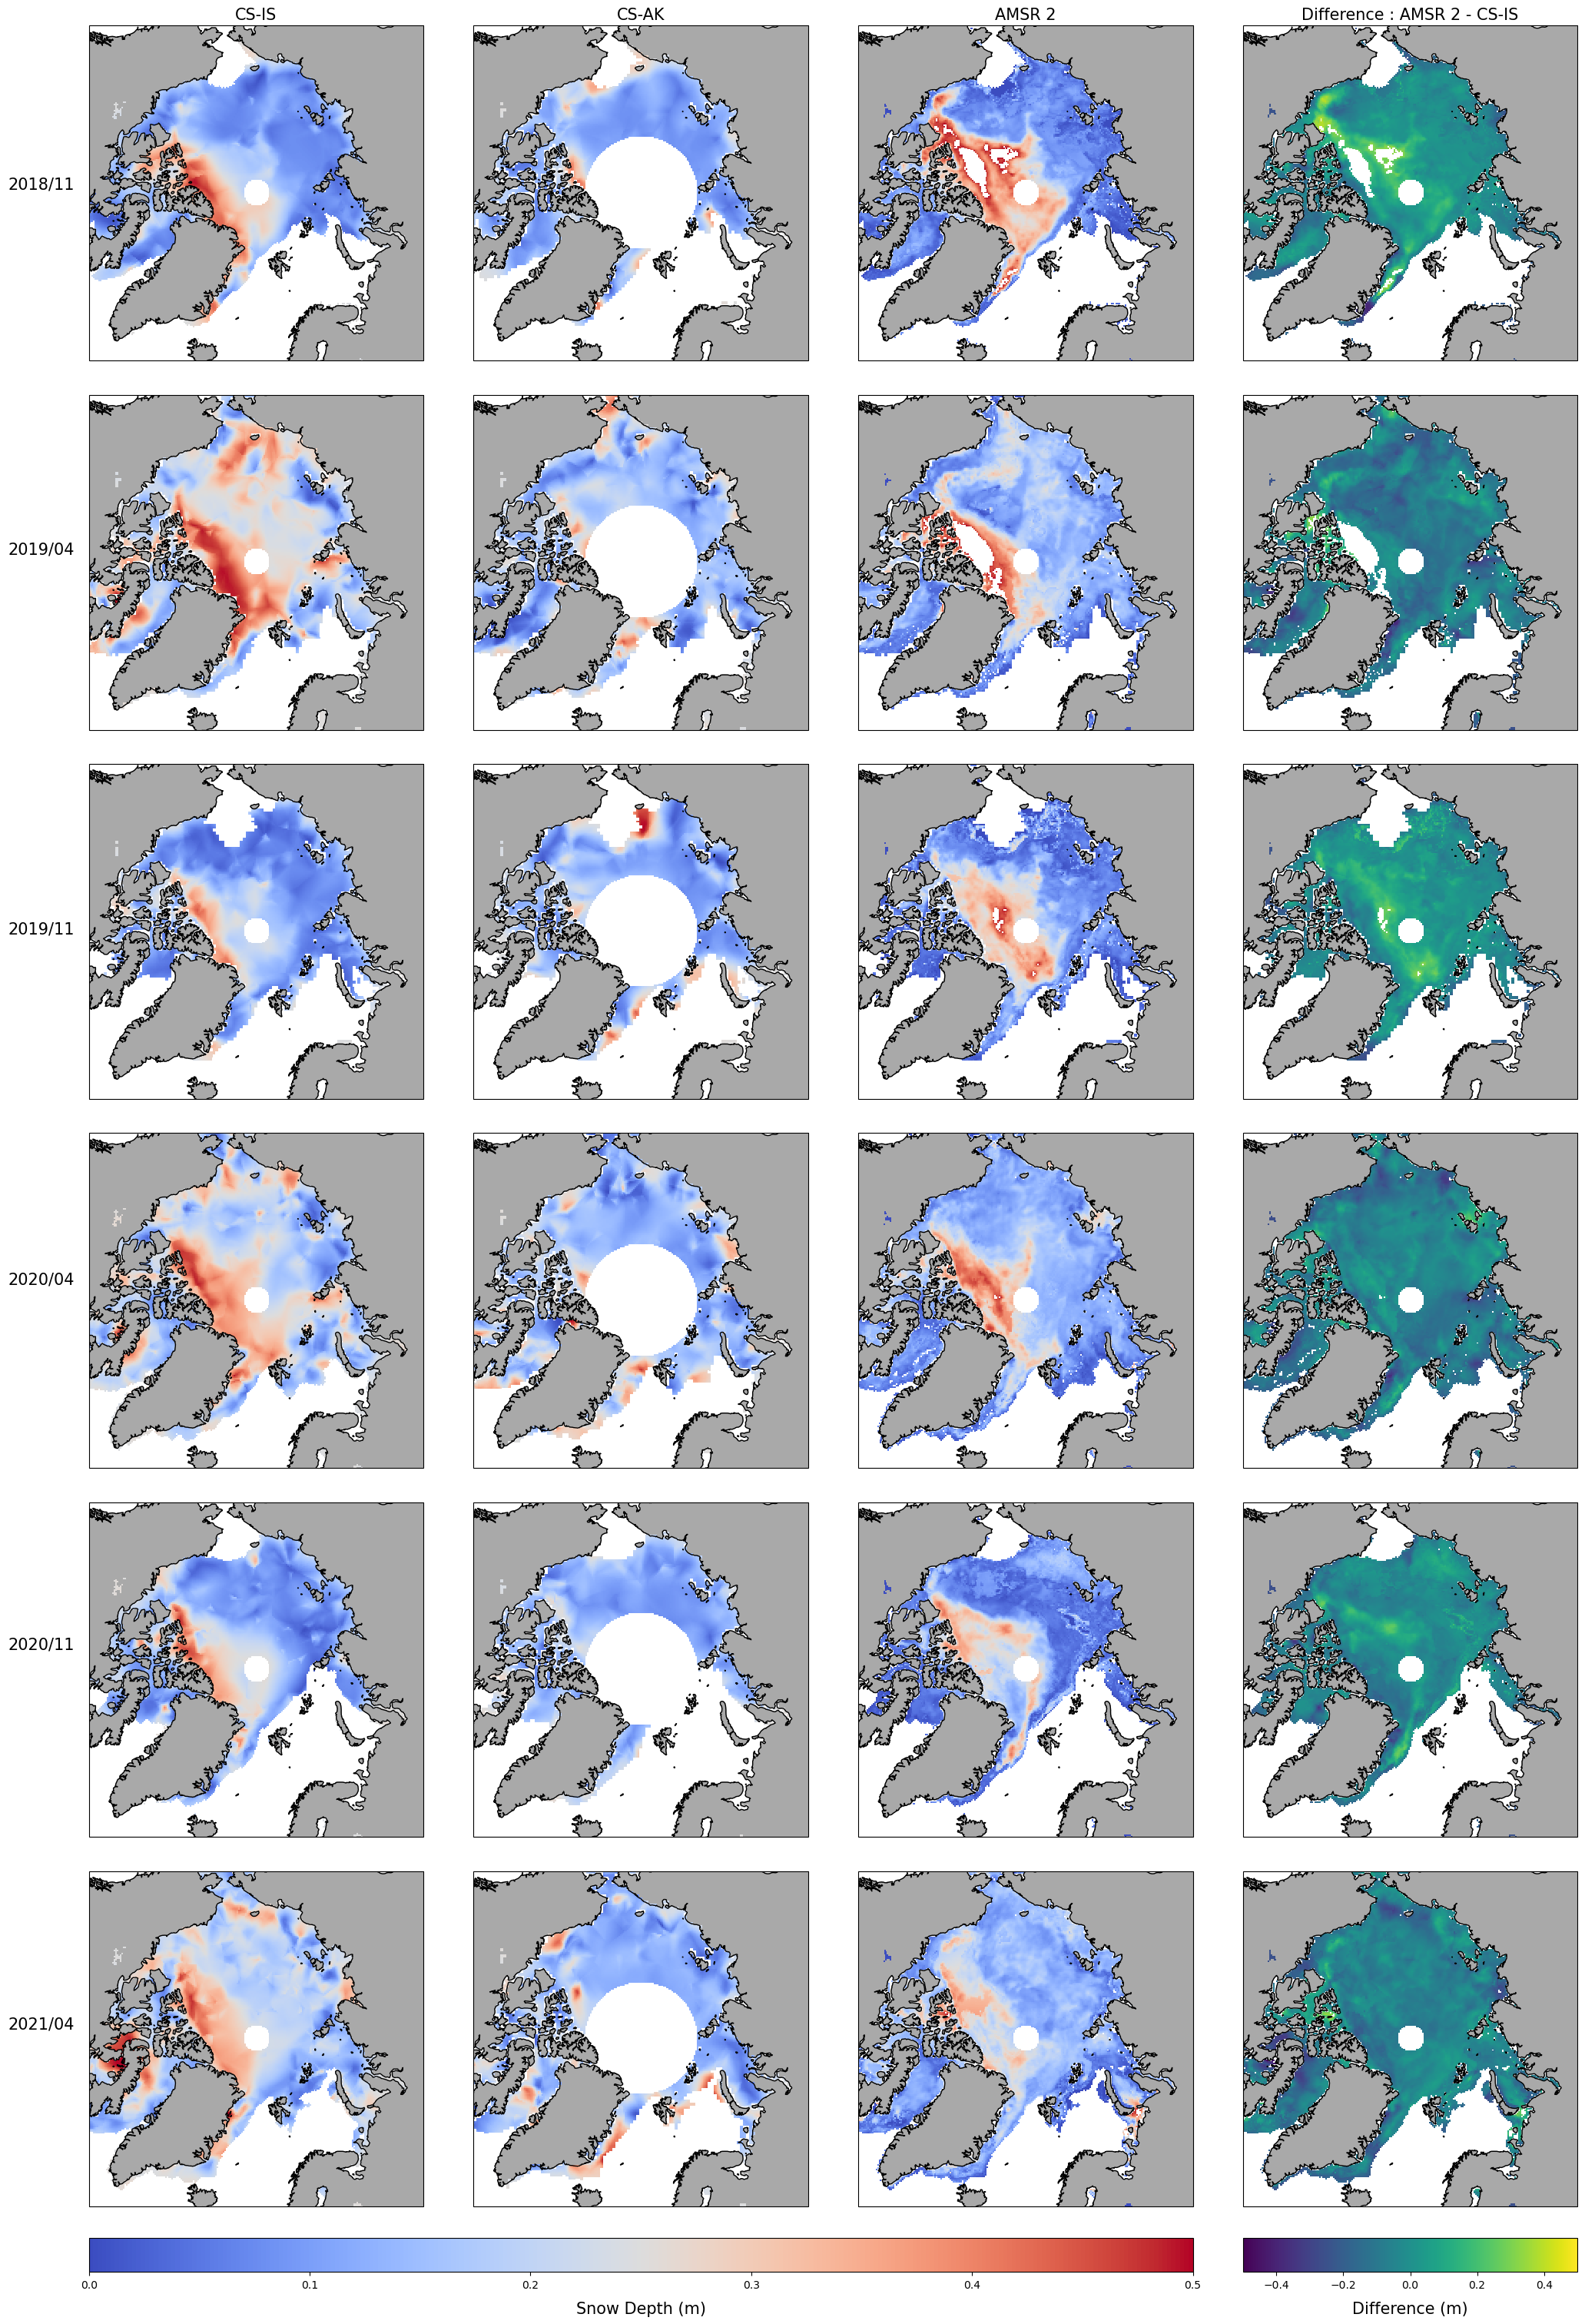

In [5]:
fig = plt.figure(figsize=(25,38))
spec = gridspec.GridSpec(ncols=4, nrows=7, hspace=0.1, wspace=0.15, height_ratios=[1,1,1, 1, 1, 1, 0.1])


months = ["November 2018", "April 2019", "November 2019", "April 2020", "November 2020", "April 2021"]
date = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")


inverse_map_CSIS = [np.load(inverseCSIS20182019[0]), np.load(inverseCSIS20182019[5]), np.load(inverseCSIS20192020[0]), 
                    np.load(inverseCSIS20192020[5]), np.load(inverseCSIS20202021[0]), np.load(inverseCSIS20202021[5])]


inverse_map_CSAK = [np.load(inverseCSAK20182019[0]), np.load(inverseCSAK20182019[5]), np.load(inverseCSAK20192020[0]), 
                    np.load(inverseCSAK20192020[5]), np.load(inverseCSAK20202021[0]), np.load(inverseCSAK20202021[5])]

for i in range(6):
    ax = fig.add_subplot(spec[i,0],projection=ccrs.NorthPolarStereo())

    if i == 0: 
        ax.set_title('CS-IS', fontsize = 15)
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()  
    p_map = ax.pcolormesh(lon_g,lat_g, inverse_map_CSIS[i],cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)


    ax2 = fig.add_subplot(spec[i,1],projection=ccrs.NorthPolarStereo())
    if i == 0:
        ax2.set_title('CS-AK', fontsize = 15)
    ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax2.coastlines()  
    p_map = ax2.pcolormesh(lon_g,lat_g, inverse_map_CSAK[i],cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)

    ax3 = fig.add_subplot(spec[i,2], projection = ccrs.NorthPolarStereo())
    if i == 0:
        ax3.set_title('AMSR 2', fontsize = 15)
    ax3.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax3.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax3.coastlines()  
    p_map = ax3.pcolormesh(lon_g,lat_g, mask_observations(IS2[i],snow_amsr2(amsr2_snow_files[i])) ,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)

    ax3 = fig.add_subplot(spec[i,3], projection = ccrs.NorthPolarStereo())
    if i == 0:
        ax3.set_title('Difference : AMSR 2 - CS-IS', fontsize = 15)
    ax3.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax3.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax3.coastlines()  
    p_map_diff = ax3.pcolormesh(lon_g,lat_g, mask_observations(IS2[i],snow_amsr2(amsr2_snow_files[i])) - inverse_map_CSIS[i] ,cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = -0.5, vmax = 0.5)


cax = fig.add_subplot(spec[24:27])
fig.colorbar(p_map, cax =cax, orientation = "horizontal")
cax.xaxis.set_ticks_position('bottom')
cax.set_xlabel('Snow Depth (m)', labelpad = 10, fontsize = 15)
cax.xaxis.set_label_position('bottom')


cax = fig.add_subplot(spec[27])
fig.colorbar(p_map_diff, cax =cax, orientation = "horizontal")
cax.xaxis.set_ticks_position('bottom')
cax.set_xlabel('Difference (m)', labelpad = 10, fontsize = 15)
cax.xaxis.set_label_position('bottom')


date = ["2018/11", "2019/04","2019/11", "2020/04", "2020/11", "2021/04"]

fig.text(0.1, 0.825, date[0], va='center', ha='center', fontsize=15)
fig.text(0.1, 0.7, date[1], va='center', ha='center', fontsize=15)
fig.text(0.1, 0.57, date[2], va='center', ha='center', fontsize=15)
fig.text(0.1, 0.45, date[3], va='center', ha='center', fontsize=15)
fig.text(0.1, 0.325, date[4], va='center', ha='center', fontsize=15)
fig.text(0.1, 0.195, date[5], va='center', ha='center', fontsize=15)

save_fig = 0
if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/figures/timeseries_amsr.png', dpi = 300)

